Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("C:/Skin-Images/Train")
data_dir_test = pathlib.Path('C:/Skin-Images/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

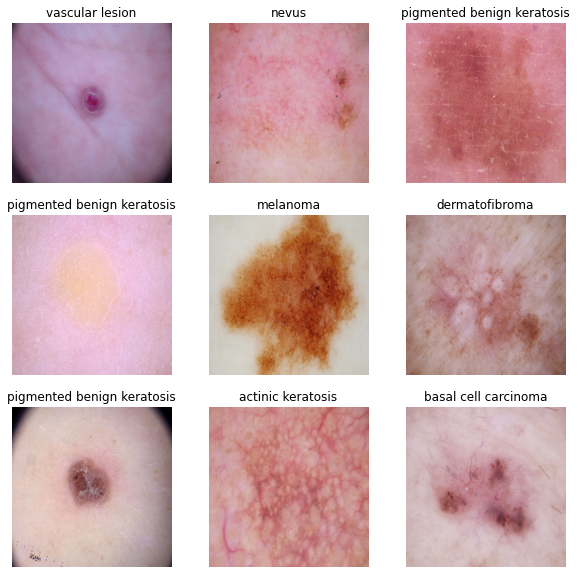

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.046078194 0.75817025


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
num_classes = 9
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 45s 578ms/step - loss: 1.9995 - accuracy: 0.2401 - val_loss: 1.7581 - val_accuracy: 0.3468
Epoch 2/20
56/56 [==============================] - 25s 453ms/step - loss: 1.6773 - accuracy: 0.3767 - val_loss: 1.4851 - val_accuracy: 0.4855
Epoch 3/20
56/56 [==============================] - 25s 446ms/step - loss: 1.4543 - accuracy: 0.4759 - val_loss: 1.3627 - val_accuracy: 0.5123
Epoch 4/20
56/56 [==============================] - 25s 445ms/step - loss: 1.3329 - accuracy: 0.5145 - val_loss: 1.3563 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 25s 442ms/step - loss: 1.2597 - accuracy: 0.5391 - val_loss: 1.3182 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 25s 446ms/step - loss: 1.1405 - accuracy: 0.5894 - val_loss: 1.2898 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 25s 444ms/step - loss: 1.1585 - accuracy: 0.5889 - val_loss: 1.4369 - val_accuracy: 0.5235

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0

### Train the model

### Visualizing training results

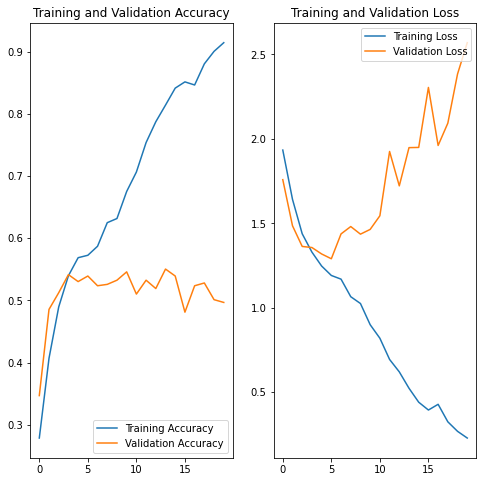

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The Training Accuracy is quite high when compared to Validation accuracy. The Model has overfit which is probably due to the less variation in the Data. Seems that the model has memorized the underlying features. 
#### The next step is to Augment the Data to increase the variation in the data

### Write your findings here

In [18]:
## Adding RandomFlip and RandomContrast layes
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.15),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [19]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 87, 87, 32)       

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 29s 510ms/step - loss: 2.1849 - accuracy: 0.2274 - val_loss: 1.7528 - val_accuracy: 0.3714
Epoch 2/20
56/56 [==============================] - 29s 512ms/step - loss: 1.6949 - accuracy: 0.4211 - val_loss: 1.6362 - val_accuracy: 0.4116
Epoch 3/20
56/56 [==============================] - 30s 534ms/step - loss: 1.6113 - accuracy: 0.4432 - val_loss: 1.5243 - val_accuracy: 0.4385
Epoch 4/20
56/56 [==============================] - 29s 513ms/step - loss: 1.5219 - accuracy: 0.4625 - val_loss: 1.5730 - val_accuracy: 0.4765
Epoch 5/20
56/56 [==============================] - 29s 521ms/step - loss: 1.4257 - accuracy: 0.4943 - val_loss: 1.4119 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 28s 507ms/step - loss: 1.3821 - accuracy: 0.5021 - val_loss: 1.4153 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 29s 512ms/step - loss: 1.3113 - accuracy: 0.5253 - val_loss: 1.4136 - val_accuracy: 0.5011

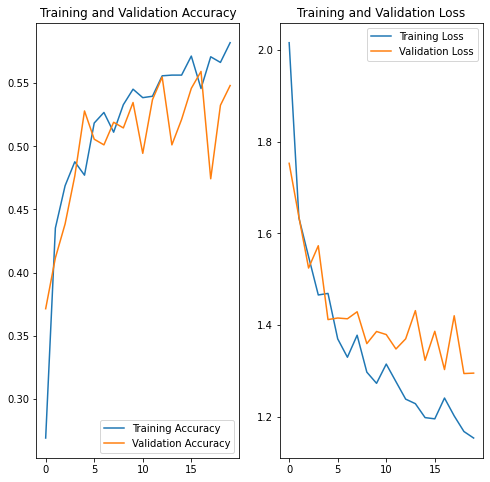

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
 # Find the distribution of classes in the training dataset
class_size = {}
for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size


{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

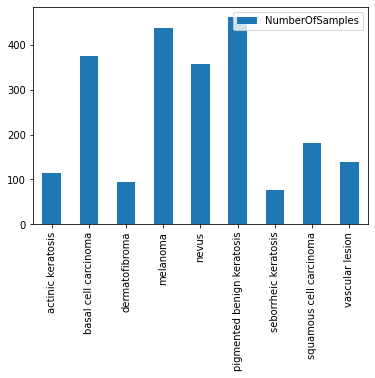

In [24]:
pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples']).plot.bar()
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [50]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("C:/Skin-Images/Train/" + i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to C:/Skin-Images/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2B5988490F0>: 100%|██████████| 500/500 [00:04<00:00, 109.05 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to C:/Skin-Images/Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2B59864D780>: 100%|██████████| 500/500 [00:03<00:00, 131.86 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to C:/Skin-Images/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2B59769FD30>: 100%|██████████| 500/500 [00:03<00:00, 132.50 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to C:/Skin-Images/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2B5987399B0>: 100%|██████████| 500/500 [00:16<00:00, 29.84 Samples/s]                    
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to C:/Skin-Images/Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x2B598661320>: 100%|██████████| 500/500 [00:16<00:00, 31.10 Samples/s] 
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to C:/Skin-Images/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2B5988AD710>: 100%|██████████| 500/500 [00:03<00:00, 146.05 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to C:/Skin-Images/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2B594922CC0>: 100%|██████████| 500/500 [00:07<00:00, 69.18 Samples/s]                   
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to C:/Skin-Images/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2B5977A0588>: 100%|██████████| 500/500 [00:03<00:00, 144.50 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to C:/Skin-Images/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2B5985DC630>: 100%|██████████| 500/500 [00:04<00:00, 118.40 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [51]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [52]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['C:\\Skin-Images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_135c1890-d753-436c-8bb8-68674a64a10d.jpg',
 'C:\\Skin-Images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3060119e-bd54-468a-8fbc-93223d4161d7.jpg',
 'C:\\Skin-Images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_5c68c33d-674f-4319-82d4-4578e5c62f56.jpg',
 'C:\\Skin-Images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_ddcccf74-4512-492c-8818-7cc58f84635f.jpg',
 'C:\\Skin-Images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_d2ed140a-29ca-4a95-afbe-b029ec95e85b.jpg',
 'C:\\Skin-Images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_edc9f887-8566-46e6-8ab8-030a13e84d35.jpg',
 'C:\\Skin-Images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_fdd55ebe-82cc-4ad0-aab1-f8f4efed25fe.jpg',
 'C:\\Skin-Images\\T

In [53]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [54]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [55]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [56]:
val_ds  = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [57]:
num_classes = 9
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),
    
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),
    
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [58]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

#### **Todo:**  Train your model

In [59]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 283s 2s/step - loss: 3.5081 - accuracy: 0.2901 - val_loss: 18.6597 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 261s 2s/step - loss: 1.4892 - accuracy: 0.4255 - val_loss: 8.0020 - val_accuracy: 0.1396
Epoch 3/30
169/169 [==============================] - 222s 1s/step - loss: 1.3283 - accuracy: 0.5087 - val_loss: 4.1032 - val_accuracy: 0.3853
Epoch 4/30
169/169 [==============================] - 257s 2s/step - loss: 1.1157 - accuracy: 0.5757 - val_loss: 2.4215 - val_accuracy: 0.3979
Epoch 5/30
169/169 [==============================] - 234s 1s/step - loss: 0.9938 - accuracy: 0.6246 - val_loss: 1.6163 - val_accuracy: 0.5033
Epoch 6/30
169/169 [==============================] - 247s 1s/step - loss: 0.8307 - accuracy: 0.6901 - val_loss: 1.7032 - val_accuracy: 0.4722
Epoch 7/30
169/169 [==============================] - 243s 1s/step - loss: 0.8048 - accuracy: 0.7068 - val_loss: 1.3789 - val_accuracy: 0.567

#### **Todo:**  Visualize the model results

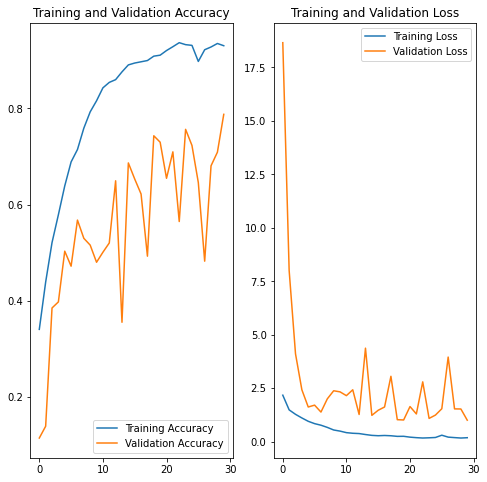

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [61]:
train_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

## Model with Data Augmentation Layers and Augmentor Data

In [77]:
num_classes = 9
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.Dropout(0.20),
    
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
w tf.keras.layers.Dropout(0.20),
    
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Dropout(0.20),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])


In [78]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [79]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 136s 792ms/step - loss: 2.3149 - accuracy: 0.1344 - val_loss: 2.1776 - val_accuracy: 0.2056
Epoch 2/30
169/169 [==============================] - 151s 888ms/step - loss: 2.0378 - accuracy: 0.2206 - val_loss: 1.8177 - val_accuracy: 0.2925
Epoch 3/30
169/169 [==============================] - 140s 817ms/step - loss: 1.6955 - accuracy: 0.3571 - val_loss: 1.6820 - val_accuracy: 0.4031
Epoch 4/30
169/169 [==============================] - 133s 779ms/step - loss: 1.5707 - accuracy: 0.3963 - val_loss: 1.4534 - val_accuracy: 0.4618
Epoch 5/30
169/169 [==============================] - 141s 827ms/step - loss: 1.4890 - accuracy: 0.4154 - val_loss: 1.5878 - val_accuracy: 0.4224
Epoch 6/30
169/169 [==============================] - 141s 829ms/step - loss: 1.4666 - accuracy: 0.4360 - val_loss: 1.6459 - val_accuracy: 0.3950
Epoch 7/30
169/169 [==============================] - 145s 848ms/step - loss: 1.4504 - accuracy: 0.4421 - val_loss: 1.3839 -

KeyboardInterrupt: 

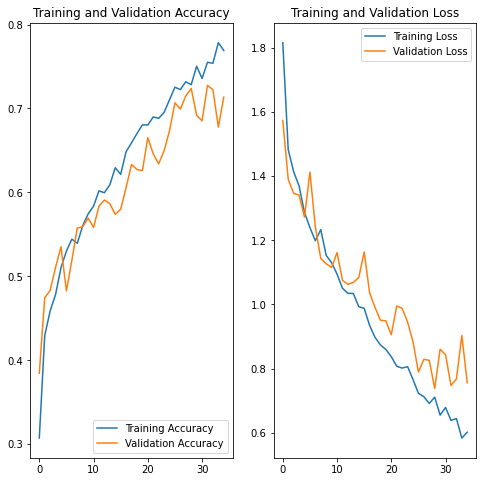

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()